# Delayed tasks analysis


### Convert notebook to python
```
bash
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20221201_073500_reaching_go_spout_bar_nov22.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20221201_073500_reaching_go_spout_bar_nov22"
```

Quick analysis of instrumental reaching

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *



### Variables

In [2]:
import pandas as pd

trial_window = [-4000, 8000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [1000, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params\\tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

# photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
photometry_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pyphotometry'
pycontrol_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pycontrol'
# video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'
tasks = pd.read_csv(tasksfile, usecols=[1, 2, 3, 4], index_col=False)


### Create an experiment object


In [5]:
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(folder_path=pycontrol_dir, int_subject_IDs=True, update=True, verbose=False)

In [ ]:
[print(session.task_name, session.subject_ID, session.datetime) for session in exp_cohort.sessions]
print(len(exp_cohort.sessions ))

### Perform extraction of behavioural information by trial

In [6]:
# Process the whole experimental folder by trials


exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, verbose=True)

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

processing by trial: JC318L-2022-12-07-184014.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC316L-2022-12-08-125551.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC317L-2022-12-08-125551.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC316L-2022-12-08-142630.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC317L-2022-12-08-142630.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC318L-2022-12-08-142910.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC316L-2022-12-08-143046.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC317L-2022-12-08-143046.txt task: reaching_go_spout_bar_dual_dec22
processing by trial: JC316L-2022-12-09-171925.txt task: reaching_go_spout_bar_dual_all_reward_dec22
processing by trial: JC317L-2022-12-09-171926.txt task: reaching_go_spout_bar_dual_all_reward_dec22
processing by trial: JC318L-2022-12-09-172140.txt task: reaching_go_spout_bar_dual_all_r

### Conditions for delayed go

In [15]:
# Defime each trial type as a dictionary of conditions to be met
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'hold_for_water', 'valid': True, 'hold_timer': True, 
    'water by bar_off': False, 'water for free': False} 
conditions_dict2 = {'trigger': 'hold_for_water', 'valid': True, 'hold_timer': False} #, 'button_press': False}

# conditions_dict2 = {'trigger': 'hold_for_water', 'spout':False, 'valid': True, 'busy_win_timer': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2]
# Aliases for conditions
cond_aliases = ['Go - hold', 'Go - aborted']
# Groups as a list of lists
# groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
groups = None

# Window to exctract (in ms)


In [ ]:
ev_dataset = exp_cohort.behav_events_to_dataset(
        groups = groups,
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when =['2022-11-08',...,'2022-12-25'], 
        task_names = ['reaching_go_spout_nov22','reaching_go_spout_bar_nov22', 'reaching_go_spout_bar_dual_dec22' ,'reaching_go_spout_bar_dual_all_reward_dec22'], #'pavlovian_nobar_nodelay', #'reaching_go_nogo',
        trig_on_ev = None)

ev_dataset.set_trial_window(trial_window=trial_window, unit='milliseconds')
ev_dataset.set_conditions(conditions=condition_list, aliases=cond_aliases)

In [ ]:
tf = (ev_dataset.get_tfkeep_subjects(316)) & (ev_dataset.get_tfkeep_dates(date(2022,12,9)))

# ev_dataset.set_keep(tf)

ev_dataset.plot_raster(keys=['bar_off_trial_time','spout_trial_time'])


Behaviour: Compute distribution

In [ ]:
dist_as_continuous = ev_dataset.compute_distribution(
        trial_window = [-1999, 10000],
        bin_size = 100, # do not work as expected with cued-uncued
        normalize = True,
        per_session = True,
        out_as_continuous = True)
dist_as_continuous.set_conditions(conditions=condition_list, aliases=cond_aliases)
# Remove test files
# dist_as_continuous.filterout_subjects([0])

### Optional methods

- Implementation of these optional filtering options is first understood as removing subjects, groups, conditions...
- It is a non-permanent way of discarding elements for analysis
- It is based on a "keep" column in the metadata that is True by default and set to False with the filtering function.
- At anytime, <trial_dataset>.filter_reset() can be called to re-include all the elements in the analysis (set all "keep" to True)
- Comment or uncomment lines and fill the lists according to your needs

In [ ]:
# Get a list of the groups
dist_as_continuous.get_groups()
# Get a list of the variables
dist_as_continuous.get_col_names()

# reset previous filtering of the dataset
dist_as_continuous.filter_reset()

# exclude some conditions by IDs
# dist_as_continuous.filter_out_conditions([])

# # exclude some groups by IDs
# dist_as_continuous.filter_out_groups([])

# exclude some subjects
dist_as_continuous.filterout_subjects([313,314,315])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# dist_as_continuous.filterout_dates([])

# filter subjects/sessions with less than x trials (by condition)
# dist_as_continuous.filter_min(min_trials = 1)

# To remove subjects who do not have trials
# in all the conditions, if called after filter_min(),
# will discard any subject who do not have the minimum number
# of trials in all the conditions

# dist_as_continuous.filter_if_not_in_all_cond()


Behaviour: Plot distribution

In [ ]:
dist_as_continuous.lineplot(
    vars = [ 'bar_off_dist','spout_dist'],
    time_lim = [-1999,6000],
    error = True,
    ylim = None,#[[-0.1,1.6]], #[[-0.1, 0.7]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (15,10),
    dpi = 100,
    verbose = False)
# Return a count of overall number of trials
dist_as_continuous.metadata_df['keep'].value_counts()

## Match and synchronize photometry to behaviour

In [8]:
# Find if there is a matching photometry file:
exp_cohort.match_sessions_to_files(photometry_dir, ext='ppd')

# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.sync_photometry_files(2)
exp_cohort.save()


c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)


saved C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pycontrol\sessions.pkl


### Extract Photometry trials and create a Continuous_Dataset

In [18]:
trial_window = [-3000, 5000]

cont_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases,
        trial_window = trial_window,
        when = 'all', 
        task_names = ['reaching_go_spout_nov22','reaching_go_spout_bar_nov22', 'reaching_go_spout_bar_dual_dec22' ,'reaching_go_spout_bar_dual_all_reward_dec22'],
        trig_on_ev = None, # align to the first event of a kind e.g. bar_off
        high_pass = None, 
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        remove_artifacts = False, # To Deprecate in favor of Exp level artifact clustering
        verbose = True) # will plot all the process of remove_artifacts if remove_artifacts == True


Processing subject 316 at: 2022-12-08 12:55:51
condition 0 trials: 6
condition 1 trials: 3
Processing subject 316 at: 2022-12-08 14:26:30
condition 0 trials: 3
condition 1 trials: 1
Processing subject 316 at: 2022-12-08 14:30:46
condition 0 trials: 57
condition 1 trials: 72
Processing subject 316 at: 2022-12-17 11:10:37
condition 0 trials: 34
condition 1 trials: 4
Processing subject 316 at: 2022-12-19 09:42:41
condition 0 trials: 19
condition 1 trials: 7
Processing subject 316 at: 2022-12-19 11:15:41
condition 0 trials: 75
condition 1 trials: 19
Processing subject 317 at: 2022-12-15 14:55:30
condition 0 trials: 0
condition 1 trials: 0
No trial in any condition for subject 317 at: 2022-12-15 14:55:30
Processing subject 317 at: 2022-12-15 15:00:40
condition 0 trials: 21
condition 1 trials: 39
Processing subject 317 at: 2022-12-15 16:02:18
condition 0 trials: 11
condition 1 trials: 1
Processing subject 317 at: 2022-12-16 17:31:45
condition 0 trials: 7
condition 1 trials: 12
Processing sub

### Save photometry dataset

In [ ]:
output_folder = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\outputs'

cont_dataset.save(output_folder, 'photo_delayed_reaching_mf3_lp45_bar_off')

### Reload a pre-existing dataset

In [ ]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\outputs\photo_delayed_reaching_mf3_lp45_CS.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [19]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filterout_conditions([])

# exclude some groups by IDs
cont_dataset.filterout_groups([])

# exclude some subjects
cont_dataset.filterout_subjects([0,1,313,314,317,318])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 7)

# Keep only last n sessions
# cont_dataset.filter_lastNsessions(n = 5)

# Filter artifacted trials
# cont_dataset.filterout_clusters([-1, 1, 2]) # Good cluster is classically 0

# Exclude sessions by dates
# cont_dataset.filterout_dates(days_to_exclude = )

# To remove subjects who do not have
# trials in all the conditions
# Careful when using on sessions when not all conditions are present, 
# it could exclude a big number of whole sessions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

cond_ID: 0, group_idx 0, subj 316
cond_ID: 1, group_idx 0, subj 316


False    662
True     300
Name: keep, dtype: int64

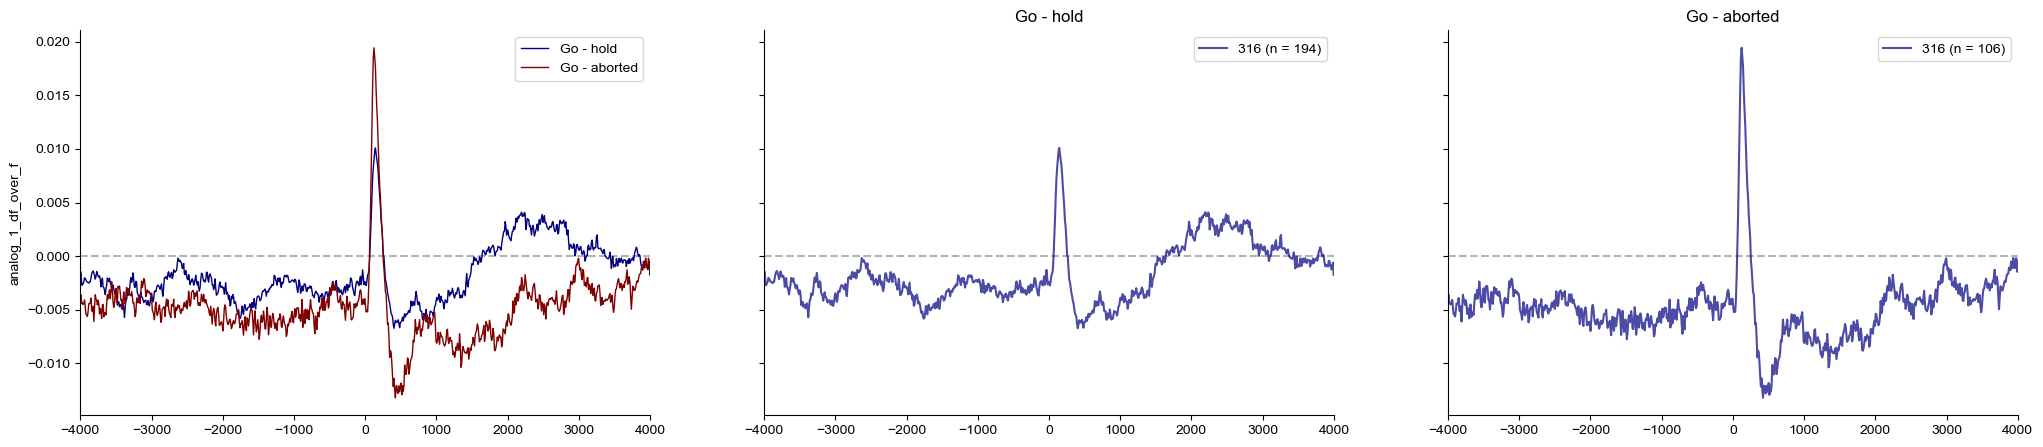

In [20]:
# Remove this method or make private
# cont_dataset.set_trial_window([-5, 10], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-4000, 4000],
    # time_unit = 'seconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (25, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



### Cluster trials to exclude artifacts

c:\Users\phar0732\Anaconda3\envs\trialexp\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Estimated number of clusters: 2
Estimated number of noise points: 37
Silhouette Coefficient: 0.512
samples per cluster:   0    799
 1    126
-1     37
dtype: int64


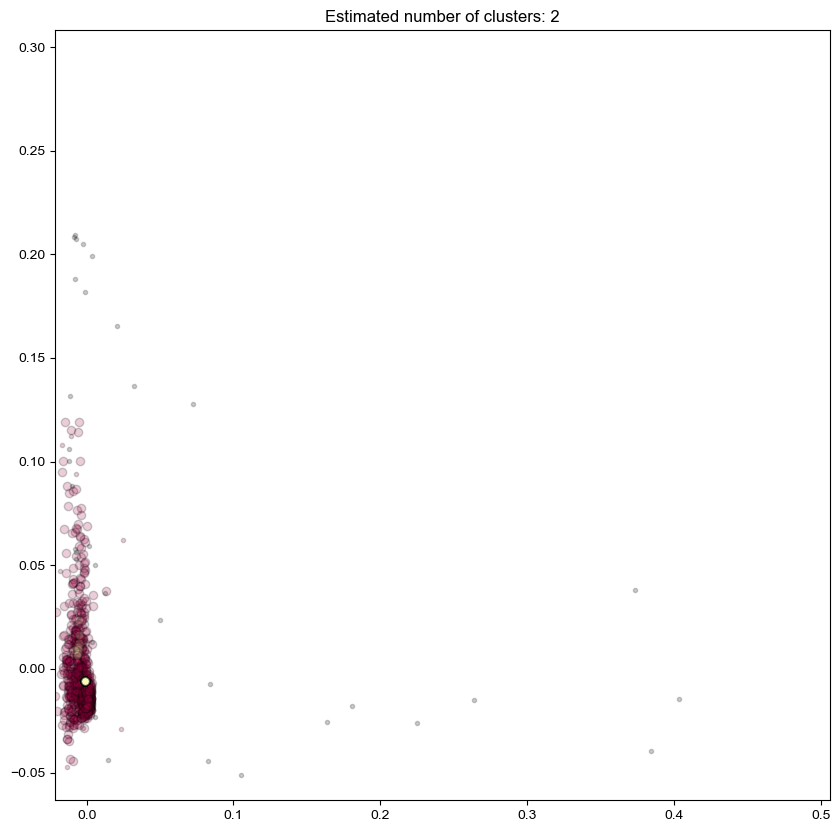

In [41]:
cont_dataset.cluster_trials(
            vars_to_cluster_on = 'analog_2',  # only work with one var for now.
            dim_reduc_type = 'ICA',
            eps =  0.05,
            min_samples_by_cluster = 5, 
            plot = True,
            plot_lim_pctile = 0.01
            )
        

### Plot the different clusters of trials

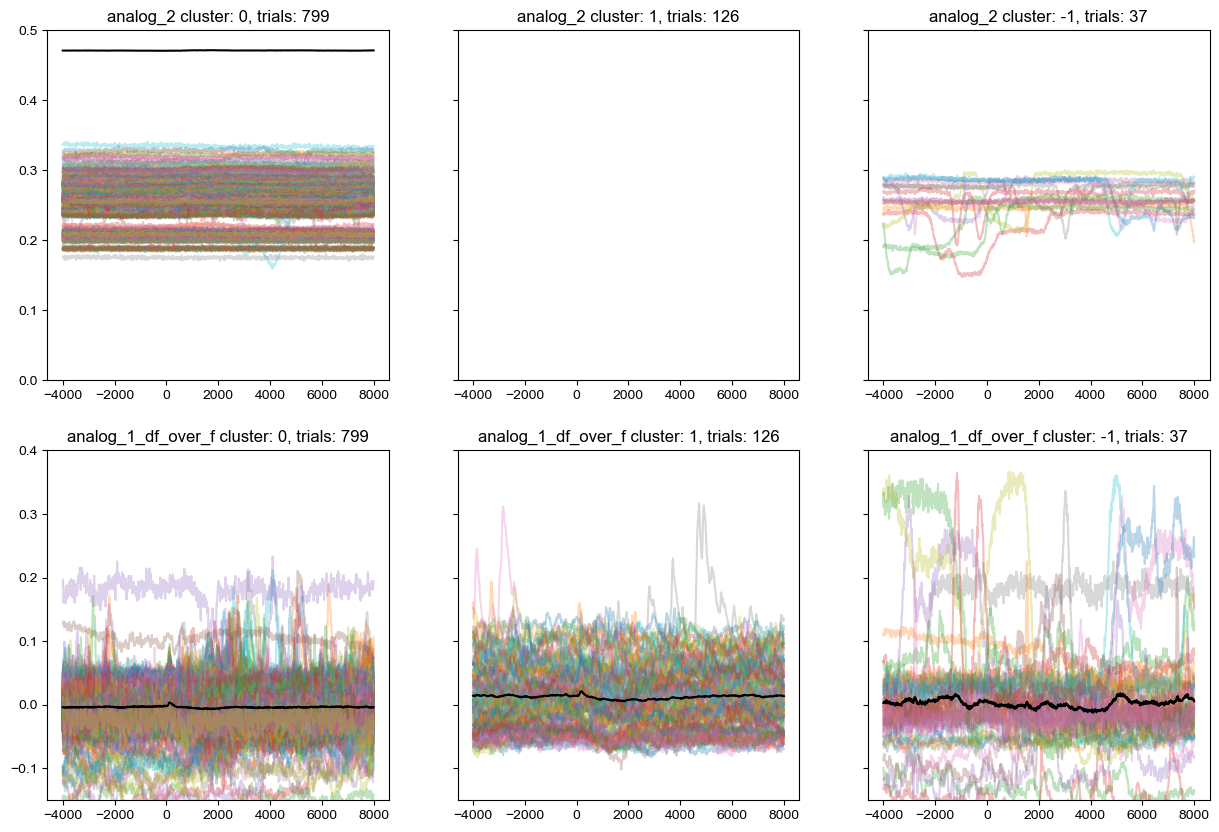

In [42]:
cont_dataset.plot_clustered_trials(
    vars_to_plot = ['analog_2','analog_1_df_over_f'],
    min_cluster_size_to_plot = 1,
    ylims = [[0,0.5],[-0.15,0.4]],
    figsize = (15,10)
    )

## Inspecting objects attributes and methods

### Experiment object after simple photometry plotting

In [43]:
object_to_inspect = exp_cohort

object_methods = [method_name for method_name in dir(object_to_inspect)
                  if (callable(getattr(object_to_inspect, method_name)) and ('__' not in method_name))]

object_attributes = [attribute_name for attribute_name in dir(object_to_inspect)
                  if (not callable(getattr(object_to_inspect, attribute_name)) and ('__' not in attribute_name))]

print(f'methods:\n\n{object_methods}, \n\nattributes\n\n{object_attributes}')

methods:

['behav_events_to_dataset', 'check_groups', 'get_deeplabcut_groups', 'get_photometry_groups', 'get_sessions', 'list_vids_to_run_in_dlc', 'match_sessions_to_files', 'plot', 'process_exp_by_trial', 'save', 'sync_photometry_files'], 

attributes

['_sessions', 'by_trial', 'folder_name', 'n_subjects', 'path', 'sessions', 'sessions_per_subject', 'subject_IDs', 'task_names', 'trial_window']


### Session object after simple photometry plotting

In [44]:
object_to_inspect = exp_cohort.sessions[0]

object_methods = [method_name for method_name in dir(object_to_inspect)
                  if (callable(getattr(object_to_inspect, method_name)) and ('__' not in method_name))]

object_attributes = [attribute_name for attribute_name in dir(object_to_inspect)
                  if (not callable(getattr(object_to_inspect, attribute_name)) and ('__' not in attribute_name))]

print(f'methods:\n\n{object_methods}, \n\nattributes\n\n{object_attributes}')

methods:

['compute_behav_metrics', 'compute_conditions_by_trial', 'compute_success', 'compute_trial_nb', 'create_metadata_dict', 'extract_data_from_session', 'get_analog_trial', 'get_deeplabcut_trials', 'get_photometry_trials', 'get_session_by_trial', 'get_task_specs', 'get_trials_times_from_conditions', 'plot_session', 'plot_trials_events'], 

attributes

['analyzed', 'conditions', 'datetime', 'datetime_string', 'df_conditions', 'df_events', 'events', 'events_to_process', 'experiment_name', 'file_name', 'files', 'metadata_dict', 'number', 'photometry_rsync', 'print_lines', 'setup_ID', 'subject_ID', 'task_name', 'timelim', 'times', 'triggers']
